In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from fastai.vision.all import *
from PIL import Image
import os
import shutil
import pathlib
import torch
from os import listdir
from os.path import isfile, join

In [2]:
# load the segmentation masks (in run-length encoding format)
masks_rle = pd.read_csv('../airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')

# select the names of images that have a ship
# 
# images that have a ship have str as the type of EncodedPixels, while images that 
# do not have a ship have float as the type of EncodedPixels
# 
# reference for lambda function: https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()
print('Number of images with ships:', len(ship_images))

Number of images with ships: 42556


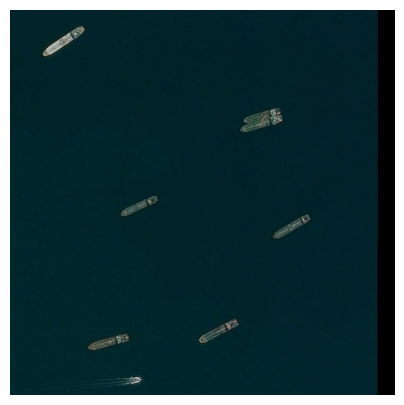

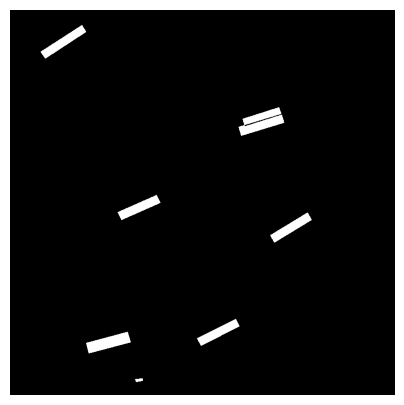

In [4]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        mask = mask.split()
        mask = [int(i) for i in mask]
        for i in range(0, len(mask), 2):
            image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

img_id = '0e9014ce4.jpg'
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(np.array(Image.open('../airbus_dataset/train_valid/' + img_id)))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(get_image_mask(img_id), cmap='Greys_r')


In [5]:
# save all the masks (targets) as png files
#   path - folder in which to save the images
#   images - images for which to save masks
def save_masks_png(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # check that the image contains a ship
        if image in ship_images:

            # get the corresponding mask as numpy array
            mask = get_image_mask(image)
            mask_img = Image.fromarray(mask).convert('RGB')
            mask_img.save(path + image[:-4] + '_P.png')

# save_masks_png('../airbus_dataset/train_v2_labels/', ship_images)

# check how many files are in the labels directory
c = 0
for file in os.listdir('../airbus_dataset/train_v2_labels/'):
    c += 1
print('Number of labels:', c)

Number of labels: 42556


In [3]:
# split the data into train, validation and test
# only use images that contain at least one ship
# 
#   train: 30K images
#   validation: 6K images
#   test: approx. 6K (rest of images with ships in them)
# 
# the sets will contain image ids

# first split into train + validation and test
train_validation_data, test_data = train_test_split(ship_images, train_size=36000)

# further split into train and validation
train_data, validation_data = train_test_split(train_validation_data, train_size=30000)

print('Images in training dataset:', len(train_data))
print('Images in validation dataset:', len(validation_data))
print('Images in test dataset:', len(test_data))

# need to copy all images in the train + validation subset to another folder,
# in order to use the fast.ai functions to create a datablock

# remove all files currently in the train_valid folder
# for file in os.listdir('../airbus_dataset/train_valid'):
#     os.remove('../airbus_dataset/train_valid/' + file)

# # copy all files in the train + validation subset to the train_valid subfolder
# for file in train_validation_data:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/train_valid/' + file
#     shutil.copy(src, dst)

# print the number of files in the train_valid folder
c = 0
for file in os.listdir('../airbus_dataset/train_valid/'):
    c += 1
print('\nNumber of training and validation images:', c)

Images in training dataset: 30000
Images in validation dataset: 6000
Images in test dataset: 6556

Number of training and validation images: 36000


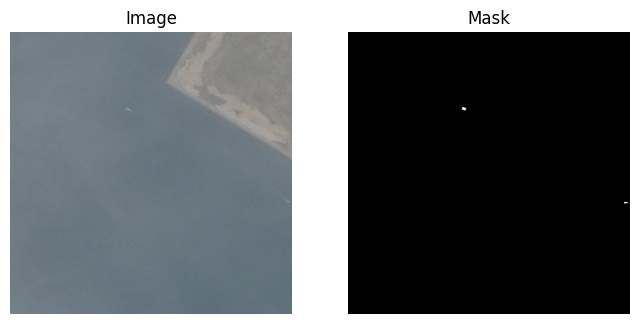

In [40]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

# create a dataset from the datablock
dsets = dblock.datasets(path/'../airbus_dataset/train_valid/')

# show an example of training image and its corresponding mask
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(dsets.train[0][0])
plt.axis('off')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.imshow(dsets.train[0][1], cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

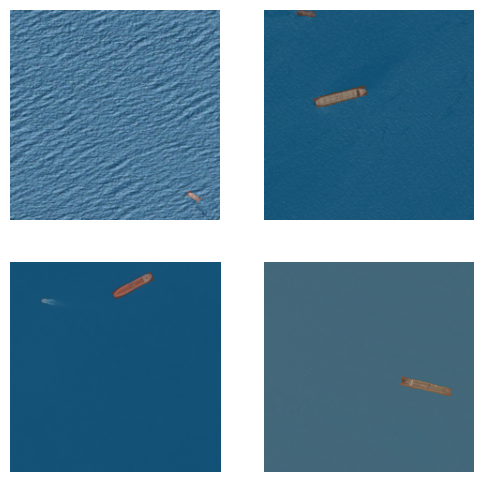

In [5]:
# create a dataloader
dls = dblock.dataloaders(path/'../airbus_dataset/train_valid/', bs=4, device=torch.device('cuda'))
dls.show_batch()

In [9]:
# create a unet learner
learn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

learn.summary()

/home/stefan/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stefan/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 4 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 56 x 56   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 28 x 28   
MaxPool2d                                   

In [10]:
import os
# torch.cuda.init()
# os.environ['CUDA_VISIBLE_DEVICES']='2'

### 1st TRAINING PHASE ###
# freeze encoder
# one cycle policy
# lr = 1e-4
# 3 epochs
learn.fit_one_cycle(3)

### 2nd TRAINING PHASE ###
# unfreeze encoder
# 4 more epochs
# other hyperparameters are the same
learn.unfreeze()
learn.fit_one_cycle(4)

# same the model
print('Saving model...')
learn.save('unet_googlenet')
print('Saved model!')

epoch,train_loss,valid_loss,time
0,0.001634,0.001611,1:18:34
1,0.001083,0.001089,1:18:35
2,0.000780,0.001021,1:18:37


epoch,train_loss,valid_loss,time
0,0.000919,0.001129,1:19:23
1,0.000749,0.000941,1:19:21
2,0.000603,0.000825,1:19:22
3,0.000572,0.000842,1:19:15


Saving model...
Saved model!


In [2]:
test1 = torch.rand(10000, 10000).to(torch.device('cuda'))
test2 = torch.rand(10000, 10000).cuda()


print(test1 * test2)

tensor([[1.4173e-01, 2.2493e-01, 1.2523e-01,  ..., 1.0282e-01, 5.2913e-01,
         8.5772e-02],
        [3.1682e-01, 5.1293e-01, 2.3525e-01,  ..., 2.4901e-04, 2.8492e-01,
         3.8503e-01],
        [3.0999e-01, 2.8160e-01, 4.0006e-01,  ..., 2.6687e-01, 1.5210e-01,
         5.0441e-01],
        ...,
        [2.4372e-01, 6.0122e-01, 6.0169e-02,  ..., 6.9443e-01, 1.2254e-03,
         1.4954e-01],
        [2.1795e-01, 3.0959e-02, 2.3738e-01,  ..., 7.3732e-01, 6.6558e-01,
         7.7859e-01],
        [8.1979e-02, 1.1424e-01, 4.1048e-01,  ..., 1.8092e-01, 1.0885e-01,
         2.0243e-01]], device='cuda:0')


## Generate the list of the images that are used for testing

In [6]:
images_used_for_training = [f for f in listdir('../airbus_dataset/train_valid/') if isfile(join('../airbus_dataset/train_valid/', f))]
images_to_test = list(set(ship_images) - set(images_used_for_training))

print("Number of images to test: " + str(len(images_to_test)))

# remove all files currently in the train_valid folder
# for file in os.listdir('../airbus_dataset/images_to_test'):
#     os.remove('../airbus_dataset/images_to_test/' + file)

# # copy all files in the train + validation subset to the train_valid subfolder
# for file in images_to_test:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/images_to_test/' + file
#     shutil.copy(src, dst)

# # print the number of files in the train_valid folder
# c = 0
# for file in os.listdir('../airbus_dataset/images_to_test/'):
#     c += 1
# print('\nNumber of test images:', c)


Number of images to test: 6556


/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


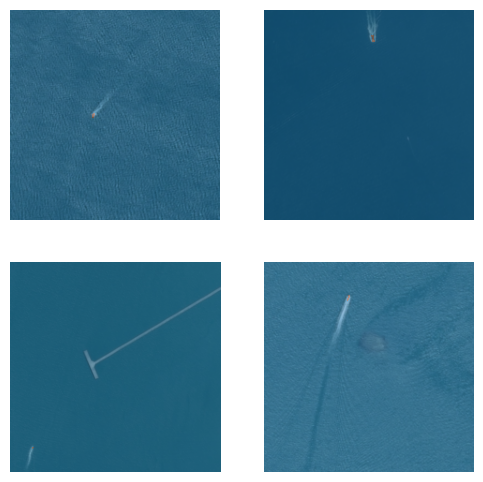

In [7]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

dls = dblock.dataloaders(path/'../airbus_dataset/images_to_test/', bs=4, device=torch.device('cuda'))
dls.show_batch()

testLearn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

testLearn.load('unet_googlenet')

## Prepare the testing dataset - run to recreate the images_to_test folder (not recomended)

In [20]:
def get_image_mask_coloured(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        mask = mask.split()
        mask = [int(i) for i in mask]
        for i in range(0, len(mask), 2):
            image_mask[mask[i]:mask[i]+mask[i+1]] = 255

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

def save_masks_png_coloured(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # check that the image contains a ship
        if image in ship_images:

            # get the corresponding mask as numpy array
            mask = get_image_mask_coloured(image)
            mask_img = Image.fromarray(mask).convert('RGB')
            mask_img.save(path + image[:-4] + '_P.png')

for file in os.listdir('../airbus_dataset/images_to_test_labels'):
    os.remove('../airbus_dataset/images_to_test_labels/' + file)
    
save_masks_png_coloured('../airbus_dataset/images_to_test_labels/', images_to_test)

## Run the testings

In [1]:
from scipy import ndimage
import skimage
import numpy
import tqdm

tp = {}
fn = {}
fp = {}
percent_iou = 0.3

recall = {}
precision = {}
F1Score = {}

for treshold in [x / 2 for x in range(-10, 11)]:
    tp[treshold] = 0
    fn[treshold] = 0
    fp[treshold] = 0

# image = '0bf71b165.jpg'
for image in tqdm(images_to_test):
    with testLearn.no_bar(), testLearn.no_logging(): _, _, outputs = testLearn.predict('../airbus_dataset/images_to_test/' + image)

    for treshold in [x / 2 for x in range(-10, 11)]:
        # cureate the image from unnecesary values ie values that have negative values and replace with 0, else with 255
        # as long as we increase the value from k to 255, the masks edges less soft
        curated_output = np.copy(outputs.numpy()[1])
        for pixel in enumerate(curated_output):
            curated_output[pixel[0]] = [(k >= treshold) * 1 for k in curated_output[pixel[0]]]

        # we create now the ground truth value (or the labeled image to check) and we reseize it to 244, 244 the size of the curated_output produced by the unet
        ground_truth_labeled_image = Image.open('../airbus_dataset/images_to_test_labels/' + image.split('.')[0] + '_P.png')
        groud_truth_value = numpy.asarray(ground_truth_labeled_image.resize(size=(224, 224)))

        # merge each pixel intro 0 or 1 probability that a ship should be there
        ground_truth_value_curated = np.zeros((groud_truth_value.shape[0], groud_truth_value.shape[1]))
        for pixel in enumerate(groud_truth_value):
            ground_truth_value_curated[pixel[0]] = [(k[0] != 0) * 1 for k in groud_truth_value[pixel[0]]]

        labels, nlabels = skimage.measure.label(curated_output > 0.9, connectivity = 2, return_num = True)
        ground_truth_labels, ground_truth_nlabels = skimage.measure.label(ground_truth_value_curated > 0.9, connectivity = 2, return_num = True)
        matched = np.empty(nlabels)
        matched.fill(0)

        for ground_truth_identificator in range(ground_truth_nlabels):
            ground_truth_tmp_image = ground_truth_labels.copy() 
            ground_truth_tmp_image[ground_truth_tmp_image != (ground_truth_identificator + 1)] = 0
            found = False

            for identificator in range(nlabels):
                tmp_image = labels.copy() 
                tmp_image[tmp_image != (identificator + 1)] = 0

                intersection = numpy.logical_and(tmp_image, ground_truth_tmp_image)
                union = numpy.logical_or(tmp_image, ground_truth_tmp_image)
                iou_score = numpy.sum(intersection) / numpy.sum(union)
                
                if iou_score > percent_iou and not matched[identificator] == 1:
                    tp[treshold] += 1
                    found = True
                    matched[identificator] = 1
                    break

            if not found:
                fn[treshold] += 1

        for identificator in range(nlabels):
            if not matched[identificator] == 1:
                fp[treshold] += 1
    
    
precision = tp /  (tp + fp)
recall = tp /  (tp + fn)
F1Score = 2 * (precision * recall) / (precision + recall)

for treshold in [x / 2 for x in range(-10, 11)]:
    precision[treshold] = tp[treshold] /  (tp[treshold] + fp[treshold])
    recall[treshold] = tp[treshold] /  (tp[treshold] + fn[treshold])
    F1Score[treshold] = 2 * (precision[treshold] * recall[treshold]) / (precision[treshold] + recall[treshold])

NameError: name 'images_to_test' is not defined

# FROM NOW THE COMPUTED VALUES

In [1]:
tp = {-5.0: 1, -4.5: 16, -4.0: 113, -3.5: 467, -3.0: 1484, -2.5: 3310, -2.0: 5139, -1.5: 7178, -1.0: 8999, -0.5: 9464, 0.0: 7392, 0.5: 4547, 1.0: 2849, 1.5: 1431, 2.0: 736, 2.5: 301, 3.0: 65, 3.5: 7, 4.0: 1, 4.5: 0, 5.0: 0}
fp = {-5.0: 273592, -4.5: 344069, -4.0: 370395, -3.5: 346692, -3.0: 338540, -2.5: 296027, -2.0: 146583, -1.5: 45523, -1.0: 13704, -0.5: 4705, 0.0: 2857, 0.5: 2535, 1.0: 2478, 1.5: 2904, 2.0: 2663, 2.5: 2231, 3.0: 2011, 3.5: 1239, 4.0: 651, 4.5: 318, 5.0: 105}
fn = {-5.0: 10965, -4.5: 10950, -4.0: 10853, -3.5: 10499, -3.0: 9482, -2.5: 7656, -2.0: 5827, -1.5: 3788, -1.0: 1967, -0.5: 1502, 0.0: 3574, 0.5: 6419, 1.0: 8117, 1.5: 9535, 2.0: 10230, 2.5: 10665, 3.0: 10901, 3.5: 10959, 4.0: 10965, 4.5: 10966, 5.0: 10966}

In [2]:
recall = {}
precision = {}
F1Score = {}

for treshold in [x / 2 for x in range(-10, 11)]:
    precision[treshold] = tp[treshold] /  (tp[treshold] + fp[treshold])
    recall[treshold] = tp[treshold] /  (tp[treshold] + fn[treshold])
    if precision[treshold] + recall[treshold] != 0 :
        F1Score[treshold] = 2 * (precision[treshold] * recall[treshold]) / (precision[treshold] + recall[treshold])
    else: 
        F1Score[treshold] = -1


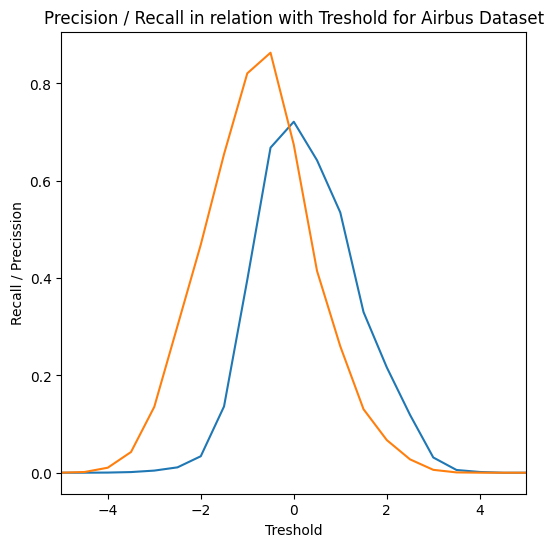

In [11]:
plt.figure(figsize=(6,6))
plt.xlabel('Treshold')
plt.ylabel('Recall / Precission')
plt.title('Precision / Recall in relation with Treshold for Airbus Dataset')
plt.xlim([-5,5])
# plt.ylim([0,1])

recall_total = []
precision_total = []

precision_total = sorted(precision.items())
xp, yp = zip(*precision_total)


recall_total = sorted(recall.items())
xr, yr = zip(*recall_total)

# for treshold in [x / 2 for x in range(-10, 11)]:
#     recall_total.append(recall[treshold])
#     precision_total.append(precision[treshold])


plt.plot(xp, yp)
plt.plot(xr, yr)
plt.show()

# TESTING STACEN

In [19]:
FILES_NAME = ['0-0-0.png', '272-512-0.png', '1203-0-0.png', '1189-0-0.png', '119-0-0.png', '1191-0-0.png', '1193-0-0.png', '1195-0-0.png', '286-0-0.png', '40-0-0.png', '479-0-0.png', '1270-0-0.png', '502-0-0.png', '1270-768-0.png', '1276-0-0.png', '1277-0-0.png', '1282-0-0.png', '1283-0-0.png', '1287-0-0.png', '1298-0-0.png', '1296-0-0.png', '1299-0-0.png', '1302-0-0.png', '1292-0-0.png', '1403-0-0.png', '1418-0-0.png', '1417-0-0.png', '1419-0-0.png', '1236-0-0.png', '1485-0-0.png', '1490-0-0.png', '1297-0-0.png', '29-512-1792.png', '29-512-1536.png', '1337-0-0.png', '25-0-1280.png', '303-256-0.png', '228-0-0.png', '296-0-512.png', '1255-0-0.png', '313-0-0.png', '360-0-0.png', '329-0-0.png', '328-0-0.png', '341-768-0.png', '362-0-0.png', '364-0-0.png', '331-0-0.png', '339-0-0.png', '379-0-0.png', '380-0-0.png', '386-0-0.png', '399-0-0.png', '409-0-0.png', '398-0-0.png', '4-0-0.png', '588-0-0.png', '536-768-512.png', '538-256-768.png', '510-768-1280.png', '510-768-512.png', '1080-0-256.png', '1080-1024-512.png', '1080-1024-0.png', '1083-0-0.png', '542-512-256.png', '543-0-512.png', '552-0-256.png', '552-0-512.png', '552-256-512.png', '574-0-0.png', '552-512-0.png', '552-512-256.png', '552-512-512.png', '552-768-512.png', '1290-0-0.png', '592-0-0.png', '622-0-0.png', '63-0-768.png', '1133-0-0.png', '1135-0-0.png', '25-1536-1024.png', '1155-0-0.png', '1080-1024-256.png', '1080-0-512.png', '1171-0-0.png', '1144-0-0.png', '1173-0-0.png', '1231-0-0.png', '1230-0-0.png', '183-256-512.png', '183-512-512.png', '1237-0-0.png', '1217-0-0.png', '1224-0-0.png', '1369-0-0.png', '139-1536-512.png', '1239-0-0.png', '235-0-0.png', '237-0-0.png', '248-0-0.png', '25-0-0.png', '1235-0-0.png', '285-0-0.png', '139-0-512.png', '262-0-0.png', '648-0-0.png', '1197-0-0.png', '120-0-0.png', '1420-0-0.png', '1040-0-0.png', '1049-0-0.png', '1055-0-0.png', '1057-0-0.png', '1063-0-0.png', '101-0-0.png', '1045-0-0.png', '105-0-0.png', '1080-0-0.png', '1080-1280-0.png', '1080-1280-256.png', '1080-1280-512.png', '1080-256-0.png', '1080-256-256.png', '1080-256-512.png', '1080-512-0.png', '1080-512-256.png', '1080-512-512.png', '1080-768-0.png', '1080-768-256.png', '109-0-0.png', '11-0-0.png', '110-0-0.png', '111-0-0.png', '112-0-0.png', '113-0-0.png', '114-0-0.png', '117-0-0.png', '118-0-0.png', '121-0-0.png', '122-0-0.png', '124-0-0.png', '125-0-0.png', '126-0-0.png', '1264-0-0.png', '1268-0-0.png', '1271-0-0.png', '1273-0-0.png', '1275-0-0.png', '1307-0-0.png', '1308-0-0.png', '132-0-0.png', '139-0-1024.png', '139-0-1280.png', '139-0-1536.png', '139-0-1792.png', '139-1024-256.png', '139-1280-0.png', '139-1280-256.png', '139-1536-0.png', '139-1536-1024.png', '139-1536-1280.png', '139-1536-768.png', '139-1792-0.png', '139-1792-1024.png', '139-1792-1536.png', '139-1792-1792.png', '139-1792-256.png', '139-1792-512.png', '139-1792-768.png', '139-256-0.png', '139-256-1280.png', '139-256-1536.png', '139-256-1792.png', '139-512-0.png', '139-512-1536.png', '139-512-1792.png', '139-512-256.png', '139-768-0.png', '139-768-1792.png', '14-0-0.png', '142-0-0.png', '143-0-0.png', '1446-0-0.png', '1455-0-0.png', '1456-0-0.png', '1458-0-0.png', '1466-0-0.png', '148-0-0.png', '15-0-0.png', '152-0-0.png', '154-0-1536.png', '156-0-0.png', '162-0-0.png', '165-0-0.png', '169-0-0.png', '17-0-0.png', '178-0-256.png', '179-0-0.png', '181-0-0.png', '183-0-0.png', '183-0-1280.png', '183-0-1792.png', '183-0-2048.png', '183-0-2304.png', '183-0-256.png', '183-1024-0.png', '183-1024-2304.png', '183-1024-256.png', '183-1024-2560.png', '183-1024-512.png', '183-1024-768.png', '183-1280-0.png', '183-1280-256.png', '183-1280-2560.png', '183-1280-512.png', '183-1536-0.png', '183-1536-2560.png', '183-1536-512.png', '183-1792-0.png', '183-1792-1024.png', '183-1792-1280.png', '183-1792-1536.png', '183-1792-1792.png', '183-1792-256.png', '183-1792-2560.png', '183-1792-512.png', '183-1792-768.png', '183-2048-0.png', '183-2048-1024.png', '183-2048-1280.png', '183-2048-1536.png', '183-2048-2048.png', '183-2048-2304.png', '183-2048-256.png', '183-2048-2560.png', '183-2048-512.png', '183-2304-0.png', '183-2304-1024.png', '183-2304-1280.png', '183-2304-2304.png', '183-2304-2560.png', '183-2304-512.png', '183-2304-768.png', '183-256-1536.png', '183-256-1792.png', '183-256-2048.png', '183-256-2560.png', '183-2560-0.png', '183-2560-1024.png', '183-2560-1280.png', '183-2560-1536.png', '183-2560-1792.png', '183-2560-2048.png', '183-2560-2304.png', '183-2560-256.png', '183-2560-2560.png', '183-2560-512.png', '183-2560-768.png', '183-512-1792.png', '183-512-2048.png', '183-512-2304.png', '183-512-2560.png', '183-768-2304.png', '183-768-256.png', '183-768-2560.png', '183-768-512.png', '185-0-0.png', '186-0-0.png', '187-0-0.png', '188-0-0.png', '189-0-0.png', '190-0-0.png', '191-0-0.png', '192-0-0.png', '193-0-0.png', '194-0-0.png', '198-0-0.png', '199-0-0.png', '200-0-0.png', '201-0-0.png', '202-0-0.png', '203-0-0.png', '205-0-0.png', '206-0-0.png', '208-0-0.png', '209-0-0.png', '210-0-0.png', '212-0-0.png', '221-0-0.png', '222-0-0.png', '236-0-0.png', '242-0-0.png', '247-0-0.png', '25-0-1024.png', '25-0-768.png', '25-1536-0.png', '25-1536-256.png', '25-1536-512.png', '25-256-1024.png', '25-256-1280.png', '25-256-768.png', '25-512-1024.png', '250-0-0.png', '252-0-0.png', '257-0-0.png', '259-0-0.png', '261-0-256.png', '267-0-0.png', '268-0-0.png', '269-0-0.png', '271-0-0.png', '272-0-0.png', '272-0-256.png', '272-256-0.png', '272-512-512.png', '273-0-0.png', '273-0-256.png', '273-256-0.png', '273-512-512.png', '274-0-0.png', '276-0-0.png', '280-0-0.png', '282-0-0.png', '283-0-0.png', '29-0-512.png', '29-256-0.png', '295-0-0.png', '298-0-0.png', '299-0-0.png', '300-0-0.png', '301-0-0.png', '302-0-0.png', '303-256-512.png', '310-0-1280.png', '310-0-0.png', '311-0-0.png', '312-0-0.png', '314-0-0.png', '318-0-0.png', '321-0-0.png', '322-0-0.png', '324-0-0.png', '33-0-0.png', '330-0-0.png', '340-0-0.png', '341-0-1280.png', '341-0-768.png', '341-1536-0.png', '341-1536-512.png', '341-256-768.png', '341-256-1024.png', '341-256-1280.png', '341-512-1024.png', '341-512-1280.png', '341-768-1280.png', '348-0-0.png', '352-0-0.png', '357-0-0.png', '36-0-0.png', '366-0-0.png', '377-0-0.png', '378-0-0.png', '382-0-0.png', '388-0-0.png', '404-0-0.png', '407-0-0.png', '41-0-0.png', '411-0-0.png', '415-0-0.png', '416-0-0.png', '42-0-0.png', '420-0-0.png', '425-0-0.png', '430-0-0.png', '435-0-0.png', '439-0-0.png', '440-0-0.png', '441-0-0.png', '445-0-0.png', '443-0-0.png', '444-0-0.png', '446-0-0.png', '47-0-0.png', '474-0-0.png', '475-0-0.png', '500-0-0.png', '510-0-0.png', '510-0-1024.png', '510-0-1280.png', '510-1024-256.png', '510-0-512.png', '510-0-768.png', '510-1024-0.png', '510-1024-512.png', '510-1024-768.png', '510-256-1024.png', '510-256-1280.png', '510-512-0.png', '510-512-1280.png', '510-768-0.png', '510-768-256.png', '522-0-0.png', '524-0-0.png', '528-0-0.png', '535-0-0.png', '536-0-0.png', '536-0-512.png', '536-1024-256.png', '536-1280-0.png', '536-256-256.png', '536-1280-256.png', '536-1280-512.png', '536-1536-256.png', '536-1536-512.png', '536-256-0.png', '536-512-0.png', '538-0-1024.png', '537-0-0.png', '538-0-1280.png', '538-0-1536.png', '538-0-768.png', '538-1024-0.png', '538-1024-256.png', '538-256-0.png', '538-1024-1536.png', '538-1024-512.png', '538-256-1024.png', '538-256-1280.png', '538-256-1536.png', '538-512-1280.png', '538-512-1536.png', '538-768-0.png', '538-768-1280.png', '538-768-1536.png', '542-0-0.png', '542-0-512.png', '542-256-0.png', '542-512-512.png', '542-768-512.png', '543-0-1024.png', '543-0-768.png', '543-512-0.png', '543-512-256.png', '544-0-0.png', '545-0-0.png', '548-0-0.png', '550-0-0.png', '552-0-1024.png', '552-0-1280.png', '552-0-1536.png', '552-0-768.png', '552-1024-0.png', '552-1024-256.png', '552-256-1024.png', '552-256-1280.png', '552-256-1536.png', '552-256-768.png', '552-512-1024.png', '552-512-1536.png', '552-768-0.png', '552-768-1280.png', '552-768-256.png', '554-512-0.png', '554-0-0.png', '553-0-0.png', '59-0-0.png', '618-0-0.png', '625-0-0.png', '626-0-0.png', '64-0-1024.png', '64-0-1280.png', '64-0-256.png', '64-0-512.png', '64-0-768.png', '64-1024-1280.png', '64-1792-0.png', '64-1792-256.png', '64-1792-512.png', '64-256-1024.png', '64-256-1280.png', '64-1792-1024.png', '64-256-512.png', '64-512-1024.png', '64-512-768.png', '64-768-1024.png', '64-768-1280.png', '64-512-1280.png', '649-0-0.png', '668-0-0.png', '688-0-0.png', '689-0-0.png', '710-0-0.png', '713-0-0.png', '74-0-0.png', '75-0-0.png', '75-0-256.png', '1011-0-0.png', '170-0-256.png', '1050-0-0.png', '1052-0-0.png', '1066-0-0.png', '1084-0-0.png', '1116-0-0.png', '1119-0-0.png', '1122-0-0.png', '1123-0-0.png', '102-0-0.png', '1053-0-0.png', '1126-0-0.png', '1145-0-0.png', '116-0-0.png', '1177-0-0.png', '1016-0-0.png', '1013-0-0.png', '1124-0-0.png', '1125-0-0.png', '1021-0-0.png', '183-1536-2304.png', '183-2304-1536.png', '1128-0-0.png', '1129-0-0.png', '1132-0-0.png', '183-0-2560.png', '183-0-512.png', '1131-0-0.png', '0-0-0.png', '1134-0-0.png', '1024-0-0.png', '183-1792-2304.png', '1147-0-0.png', '1175-0-0.png', '115-0-0.png', '1149-0-0.png', '1161-0-0.png', '1151-0-0.png', '1025-0-0.png', '1162-0-0.png', '1167-0-0.png', '1170-0-0.png', '183-1280-1024.png', '0-0-256.png', '1-0-0.png', '1000-0-0.png', '1176-0-0.png', '1185-0-0.png', '1178-0-0.png', '1180-0-0.png', '1518-0-0.png', '1533-0-0.png', '183-1280-2304.png', '1183-0-0.png', '1187-0-0.png', '1002-0-0.png', '1192-0-0.png', '1196-0-0.png', '1198-0-0.png', '1200-0-0.png', '1003-0-0.png', '1202-0-0.png', '1527-0-0.png', '1005-0-0.png', '1006-0-0.png', '154-256-0.png', '1001-0-0.png', '1012-0-0.png', '1023-0-0.png', '1004-0-0.png', '1017-0-0.png', '1019-0-0.png', '1022-0-0.png', '1054-0-0.png', '1027-0-0.png', '1028-0-0.png', '103-0-0.png', '1067-0-0.png', '1068-0-0.png', '1029-0-0.png', '1153-0-0.png', '1033-0-0.png', '1056-0-0.png', '1059-0-0.png', '106-0-0.png', '1105-0-0.png', '1007-0-0.png', '1038-0-0.png', '1008-0-0.png', '104-0-0.png', '1009-0-0.png', '1069-0-0.png', '1010-0-0.png', '1039-0-0.png', '1014-0-0.png', '1041-0-0.png', '1043-0-0.png', '1042-0-0.png', '1015-0-0.png', '1018-0-0.png', '1020-0-0.png', '1058-0-0.png', '1060-0-0.png', '1104-0-0.png', '1026-0-0.png', '1089-0-0.png', '1035-0-0.png', '1030-0-0.png', '1031-0-0.png', '1032-0-0.png', '1044-0-0.png', '1047-0-0.png', '1048-0-0.png', '1061-0-0.png', '1071-0-0.png', '108-0-0.png', '1062-0-0.png', '1070-0-0.png', '1064-0-0.png', '1080-768-512.png', '1065-0-0.png', '107-0-0.png', '1085-0-0.png', '1086-0-0.png', '1087-0-0.png', '1088-0-0.png', '1090-0-0.png', '1091-0-0.png', '1034-0-0.png', '1095-0-0.png', '1096-0-0.png', '1097-0-0.png', '1098-0-0.png', '1099-0-0.png', '11-0-256.png', '1100-0-0.png', '1101-0-0.png', '1103-0-0.png', '1102-0-0.png', '1106-0-0.png', '1110-0-0.png', '1115-0-0.png', '1120-0-0.png', '1117-0-0.png', '1036-0-0.png', '1051-0-0.png', '1092-0-0.png', '1094-0-0.png', '1146-0-0.png', '1157-0-0.png', '1166-0-0.png', '1165-0-0.png', '1169-0-0.png', '1168-0-0.png', '1182-0-0.png', '1181-0-0.png', '1188-0-0.png', '1206-0-0.png', '1127-0-0.png', '1130-0-0.png', '1207-0-0.png', '1107-0-0.png', '1108-0-0.png', '1109-0-0.png', '1111-0-0.png', '1113-0-0.png', '1112-0-0.png', '1114-0-0.png', '1118-0-0.png', '1121-0-0.png', '1148-0-0.png', '1150-0-0.png', '1152-0-0.png', '1154-0-0.png', '1156-0-0.png', '1158-0-0.png', '1159-0-0.png', '1160-0-0.png', '1164-0-0.png', '1174-0-0.png', '1163-0-0.png', '1179-0-0.png', '1186-0-0.png', '1190-0-0.png', '1199-0-0.png', '1201-0-0.png', '1194-0-0.png', '1205-0-0.png', '1208-0-0.png', '1209-0-0.png', '1211-0-0.png', '1204-0-0.png', '1136-0-0.png', '1143-0-0.png', '1220-0-0.png', '1222-0-0.png', '1221-0-0.png', '1223-0-0.png', '1229-0-0.png', '123-0-0.png', '1238-0-0.png', '1240-0-0.png', '1260-0-0.png', '1251-0-0.png', '1263-0-0.png', '1272-0-0.png', '1274-0-0.png', '1281-0-0.png', '1288-0-0.png', '1289-0-0.png', '1291-0-0.png', '1294-0-0.png', '1138-0-0.png', '1140-0-0.png', '1137-0-0.png', '1300-0-0.png', '1309-0-0.png', '1139-0-0.png', '1218-0-0.png', '1141-0-0.png', '1142-0-0.png', '1210-0-0.png', '1306-0-0.png', '1172-0-0.png', '1303-0-0.png', '1225-0-0.png', '1184-0-0.png', '1304-0-0.png', '1212-0-0.png', '1227-0-0.png', '1219-0-0.png', '1214-0-0.png', '1215-0-0.png', '1213-0-0.png', '1216-0-0.png', '1228-0-0.png', '1226-0-0.png', '1232-0-0.png', '1313-0-0.png', '1233-0-0.png', '1234-0-0.png', '1318-0-0.png', '1317-0-0.png', '1241-0-0.png', '1320-0-0.png', '1242-0-0.png', '1323-0-0.png', '1244-0-0.png', '1245-0-0.png', '1325-0-0.png', '1321-0-0.png', '133-0-0.png', '1327-0-0.png', '1328-0-0.png', '1329-0-0.png', '1330-0-0.png', '1331-0-0.png', '1333-0-0.png', '1334-0-0.png', '1335-0-0.png', '1339-0-0.png', '1341-0-0.png', '1340-0-0.png', '1343-0-0.png', '1342-0-0.png', '1344-0-0.png', '1346-0-0.png', '1345-0-0.png', '1250-0-0.png', '1246-0-0.png', '1243-0-0.png', '1247-0-0.png', '1248-0-0.png', '1249-0-0.png', '1347-0-0.png', '1252-0-0.png', '1270-512-0.png', '1266-0-0.png', '1256-0-0.png', '1253-0-0.png', '1254-0-0.png', '1259-0-0.png', '1267-0-0.png', '1258-0-0.png', '1257-0-0.png', '1262-0-0.png', '1265-0-0.png', '1261-0-0.png', '127-0-0.png', '1270-256-0.png', '1270-1024-0.png', '1280-0-0.png', '1278-0-0.png', '1279-0-0.png', '128-0-0.png', '1356-0-0.png', '139-768-512.png', '1355-0-0.png', '139-256-512.png', '1400-0-0.png', '1285-0-0.png', '1284-0-0.png', '1286-0-0.png', '1357-0-0.png', '129-0-0.png', '1293-0-0.png', '1295-0-0.png', '130-0-0.png', '1301-0-0.png', '131-0-0.png', '1305-0-0.png', '1310-0-0.png', '1332-0-0.png', '1363-0-0.png', '1311-0-0.png', '1314-0-0.png', '1315-0-0.png', '1316-0-0.png', '1312-0-0.png', '1319-0-0.png', '1322-0-0.png', '1324-0-0.png', '1326-0-0.png', '1336-0-0.png', '1338-0-0.png', '1348-0-0.png', '1349-0-0.png', '1350-0-0.png', '1358-0-0.png', '1351-0-0.png', '1364-0-0.png', '1352-0-0.png', '1353-0-0.png', '1359-0-0.png', '1354-0-0.png', '1360-0-0.png', '1361-0-0.png', '1362-0-0.png', '1365-0-0.png', '1367-0-0.png', '1366-0-0.png', '1370-0-0.png', '1371-0-0.png', '1372-0-0.png', '1373-0-0.png', '1374-0-0.png', '1376-0-0.png', '1377-0-0.png', '1379-0-0.png', '1380-0-0.png', '1385-0-0.png', '1381-0-0.png', '1386-0-0.png', '172-0-0.png', '173-0-0.png', '139-0-256.png', '1389-0-0.png', '139-1024-0.png', '139-0-768.png', '139-1024-1024.png', '139-1024-1792.png', '139-1024-1280.png', '139-1024-512.png', '139-1280-1024.png', '139-1024-768.png', '139-1280-1280.png', '1442-0-0.png', '139-1280-1536.png', '139-1280-1792.png', '139-1280-768.png', '139-1280-512.png', '139-1536-256.png', '139-256-1024.png', '139-1792-1280.png', '139-256-256.png', '139-256-768.png', '139-512-1024.png', '139-512-512.png', '183-1280-768.png', '139-768-1024.png', '139-768-1280.png', '1368-0-0.png', '1375-0-0.png', '1393-0-0.png', '139-1024-1536.png', '1378-0-0.png', '1384-0-0.png', '1387-0-0.png', '1396-0-0.png', '1382-0-0.png', '1388-0-0.png', '139-0-0.png', '1383-0-0.png', '1398-0-0.png', '1397-0-0.png', '139-768-256.png', '140-0-0.png', '139-1536-1536.png', '139-1536-1792.png', '1399-0-0.png', '1394-0-0.png', '139-768-768.png', '139-512-768.png', '139-768-1536.png', '1390-0-0.png', '1391-0-0.png', '1392-0-0.png', '1401-0-0.png', '1395-0-0.png', '1402-0-0.png', '1407-0-0.png', '141-0-0.png',
              '1408-0-0.png', '1413-0-0.png', '1412-0-0.png', '1423-0-0.png', '1425-0-0.png', '1432-0-0.png', '1434-0-0.png', '1436-0-0.png', '1437-0-0.png', '1443-0-0.png', '1445-0-0.png', '1444-0-0.png', '1462-0-0.png', '1454-0-0.png', '1453-0-0.png', '1457-0-0.png', '1461-0-0.png', '1471-0-0.png', '148-0-256.png', '1480-0-0.png', '148-256-256.png', '1486-0-0.png', '139-512-1280.png', '1405-0-0.png', '1409-0-0.png', '1406-0-0.png', '1414-0-0.png', '1404-0-0.png', '1410-0-0.png', '1411-0-0.png', '1415-0-0.png', '1416-0-0.png', '1422-0-0.png', '1421-0-0.png', '1428-0-0.png', '1424-0-0.png', '1426-0-0.png', '1427-0-0.png', '1429-0-0.png', '1430-0-0.png', '1431-0-0.png', '1433-0-0.png', '1435-0-0.png', '1438-0-0.png', '1459-0-0.png', '1439-0-0.png', '1440-0-0.png', '1441-0-0.png', '1460-0-0.png', '1465-0-0.png', '1467-0-0.png', '1468-0-0.png', '1469-0-0.png', '1470-0-0.png', '1472-0-0.png', '1473-0-0.png', '1474-0-0.png', '1475-0-0.png', '1478-0-0.png', '1476-0-0.png', '1477-0-0.png', '1479-0-0.png', '1481-0-0.png', '1482-0-0.png', '149-0-0.png', '1483-0-0.png', '1484-0-0.png', '1487-0-0.png', '1489-0-0.png', '1491-0-0.png', '148-256-0.png', '1497-0-0.png', '1499-0-0.png', '150-0-0.png', '1500-0-0.png', '1504-0-0.png', '1506-0-0.png', '151-0-0.png', '1510-0-0.png', '1513-0-0.png', '1514-0-0.png', '1517-0-0.png', '1520-0-0.png', '1519-0-0.png', '1526-0-0.png', '153-0-0.png', '1535-0-0.png', '154-0-0.png', '154-0-1280.png', '154-0-1024.png', '154-0-768.png', '154-256-1024.png', '154-256-1536.png', '154-256-1280.png', '183-2048-1792.png', '1542-0-0.png', '1543-0-0.png', '1544-0-0.png', '1545-0-0.png', '1546-0-0.png', '1549-0-0.png', '25-0-256.png', '1550-0-0.png', '155-0-256.png', '155-0-0.png', '155-0-512.png', '164-0-0.png', '163-0-0.png', '159-0-0.png', '160-0-0.png', '170-0-0.png', '170-0-1024.png', '170-0-512.png', '170-0-768.png', '171-0-0.png', '177-0-0.png', '175-0-0.png', '176-0-0.png', '183-1024-1024.png', '183-1024-1792.png', '1523-0-0.png', '183-1536-256.png', '183-1024-1536.png', '1492-0-0.png', '1488-0-0.png', '183-0-768.png', '1493-0-0.png', '1494-0-0.png', '1496-0-0.png', '1508-0-0.png', '155-0-768.png', '1502-0-0.png', '183-1280-1536.png', '1501-0-0.png', '1503-0-0.png', '1505-0-0.png', '1512-0-0.png', '1515-0-0.png', '1507-0-0.png', '1509-0-0.png', '1511-0-0.png', '1516-0-0.png', '1495-0-0.png', '1521-0-0.png', '1524-0-0.png', '1498-0-0.png', '154-256-512.png', '1522-0-0.png', '183-1280-1792.png', '1525-0-0.png', '183-2304-256.png', '183-1792-2048.png', '1528-0-0.png', '1529-0-0.png', '183-1280-2048.png', '1530-0-0.png', '1532-0-0.png', '154-256-256.png', '1531-0-0.png', '1534-0-0.png', '1537-0-0.png', '1536-0-0.png', '1538-0-0.png', '1539-0-0.png', '154-0-512.png', '1541-0-0.png', '154-256-768.png', '154-0-256.png', '1540-0-0.png', '183-1536-1024.png', '183-1536-1536.png', '1547-0-0.png', '166-0-0.png', '1548-0-0.png', '1555-0-0.png', '1551-0-0.png', '1553-0-0.png', '1554-0-0.png', '1552-0-0.png', '157-0-0.png', '158-0-0.png', '161-0-0.png', '167-0-0.png', '183-1536-2048.png', '183-2304-1792.png', '168-0-0.png', '183-0-1536.png', '174-0-0.png', '180-0-0.png', '178-0-0.png', '183-1024-1280.png', '183-1024-2048.png', '183-0-1024.png', '183-256-1024.png', '183-256-1280.png', '183-256-2304.png', '183-256-0.png', '183-1280-1280.png', '183-256-768.png', '183-512-1024.png', '183-512-1536.png', '183-512-1280.png', '183-512-256.png', '183-768-1024.png', '183-768-1280.png', '183-768-2048.png', '184-0-0.png', '183-768-1536.png', '197-0-0.png', '20-0-0.png', '204-0-1024.png', '204-0-0.png', '204-0-256.png', '25-1280-1024.png', '204-0-512.png', '205-0-256.png', '205-256-0.png', '205-256-256.png', '211-0-0.png', '213-0-0.png', '22-0-0.png', '204-0-768.png', '23-0-0.png', '241-0-0.png', '238-0-0.png', '230-0-0.png', '231-0-0.png', '232-0-0.png', '239-0-0.png', '240-0-0.png', '234-0-0.png', '249-0-0.png', '25-0-512.png', '25-1024-1024.png', '25-1024-256.png', '25-1024-512.png', '25-1024-768.png', '25-1280-0.png', '25-1280-256.png', '25-1280-1280.png', '25-1280-512.png', '25-1536-1280.png', '25-256-512.png', '25-256-256.png', '25-512-256.png', '25-512-768.png', '25-512-512.png', '254-0-0.png', '25-768-1024.png', '183-1536-1280.png', '25-768-256.png', '26-0-0.png', '256-0-0.png', '25-768-512.png', '253-0-0.png', '25-768-768.png', '260-0-0.png', '260-0-1024.png', '183-2048-768.png', '183-1536-768.png', '183-512-0.png', '183-2304-2048.png', '183-256-256.png', '183-1536-1792.png', '183-768-0.png', '183-512-768.png', '260-0-512.png', '260-0-256.png', '261-0-0.png', '263-0-0.png', '260-0-768.png', '264-0-256.png', '264-0-0.png', '264-0-512.png', '264-256-256.png', '265-0-1024.png', '265-0-1280.png', '265-0-512.png', '265-256-0.png', '265-0-768.png', '326-0-0.png', '438-0-0.png', '229-0-0.png', '183-768-768.png', '265-256-1024.png', '371-0-0.png', '25-1536-768.png', '265-256-1280.png', '196-0-0.png', '183-768-1792.png', '195-0-0.png', '2-0-0.png', '245-0-0.png', '246-0-0.png', '265-256-512.png', '265-256-768.png', '25-512-1280.png', '224-0-0.png', '21-0-0.png', '244-0-0.png', '243-0-0.png', '25-1024-0.png', '25-1024-1280.png', '25-512-0.png', '25-1280-768.png', '25-256-0.png', '25-768-1280.png', '272-0-512.png', '25-768-0.png', '255-0-0.png', '258-0-0.png', '251-0-0.png', '272-256-256.png', '272-256-512.png', '272-512-256.png', '273-0-512.png', '273-256-256.png', '273-512-0.png', '273-256-512.png', '65-0-0.png', '281-0-1280.png', '279-0-0.png', '270-0-0.png', '277-0-0.png', '339-256-768.png', '281-0-0.png', '281-0-1024.png', '281-0-256.png', '281-0-512.png', '43-0-0.png', '281-0-768.png', '281-256-1024.png', '281-256-512.png', '281-256-1280.png', '281-256-256.png', '5-0-0.png', '503-0-0.png', '504-0-0.png', '505-0-0.png', '506-0-0.png', '281-256-768.png', '289-0-0.png', '29-0-1024.png', '29-0-1280.png', '29-0-1792.png', '29-0-1536.png', '29-0-256.png', '29-0-768.png', '29-256-1536.png', '29-256-1024.png', '29-512-0.png', '29-256-768.png', '29-512-512.png', '290-0-0.png', '29-512-256.png', '264-256-512.png', '292-0-0.png', '296-0-0.png', '296-0-256.png', '296-0-768.png', '3-0-0.png', '303-0-256.png', '233-0-0.png', '265-0-0.png', '303-256-256.png', '264-256-0.png', '308-0-0.png', '308-0-1280.png', '308-0-256.png', '308-0-512.png', '308-0-768.png', '308-256-1024.png', '308-256-0.png', '308-256-768.png', '310-256-0.png', '310-0-768.png', '310-256-1024.png', '308-0-1024.png', '310-256-768.png', '315-0-0.png', '325-0-0.png', '327-0-0.png', '339-0-256.png', '341-0-0.png', '310-256-1280.png', '552-1024-1024.png', '339-256-256.png', '34-0-0.png', '552-1024-1536.png', '552-1024-768.png', '339-256-512.png', '341-0-1024.png', '341-1024-0.png', '278-0-0.png', '341-0-256.png', '265-0-256.png', '265-256-256.png', '27-0-0.png', '341-1024-1024.png', '273-512-256.png', '275-0-0.png', '341-1024-1280.png', '277-0-256.png', '28-0-0.png', '281-256-0.png', '341-1024-256.png', '341-1024-512.png', '341-1024-768.png', '29-512-1280.png', '341-1280-1024.png', '341-1280-1280.png', '284-0-0.png', '341-1280-256.png', '341-1280-512.png', '341-1536-256.png', '341-256-0.png', '341-1536-1280.png', '341-256-512.png', '341-256-256.png', '341-512-512.png', '341-512-768.png', '341-768-1024.png', '343-0-0.png', '341-768-768.png', '552-256-0.png', '348-0-256.png', '64-1792-1280.png', '348-256-0.png', '376-0-256.png', '29-0-0.png', '29-256-1280.png', '29-256-256.png', '29-256-1792.png', '29-256-512.png', '29-512-1024.png', '373-0-0.png', '348-256-256.png', '367-0-0.png', '358-0-0.png', '35-0-0.png', '375-256-0.png', '375-0-1024.png', '412-0-0.png', '45-0-0.png', '375-0-256.png', '375-0-1280.png', '375-0-768.png', '375-256-1024.png', '375-256-1280.png', '375-256-1536.png', '418-0-0.png', '419-0-0.png', '375-256-768.png', '376-0-0.png', '376-0-512.png', '383-0-0.png', '395-0-0.png', '376-0-768.png', '422-0-0.png', '387-0-0.png', '384-0-0.png', '385-0-0.png', '397-0-0.png', '437-0-0.png', '405-0-0.png', '403-0-0.png', '414-0-0.png', '408-0-0.png', '410-0-0.png', '428-0-0.png', '42-0-256.png', '426-0-0.png', '436-0-0.png', '442-0-0.png', '448-0-0.png', '449-0-0.png', '47-0-256.png', '47-0-512.png', '510-512-256.png', '476-0-0.png', '47-256-512.png', '47-256-256.png', '48-0-256.png', '48-0-0.png', '510-768-1024.png', '48-0-512.png', '48-0-768.png', '49-0-256.png', '49-0-512.png', '49-0-768.png', '509-0-0.png', '509-256-0.png', '510-256-256.png', '510-256-512.png', '510-512-512.png', '510-768-768.png', '512-0-0.png', '513-0-0.png', '516-0-0.png', '519-0-0.png', '519-0-256.png', '519-0-512.png', '519-0-768.png', '526-0-0.png', '527-0-0.png', '529-0-0.png', '536-512-256.png', '552-512-768.png', '538-1024-1024.png', '538-256-256.png', '538-256-512.png', '538-512-256.png', '538-768-256.png', '539-0-0.png', '543-256-1024.png', '543-0-256.png', '543-256-768.png', '547-0-0.png', '549-0-0.png', '552-0-0.png', '543-512-768.png', '546-0-0.png', '551-0-0.png', '552-1024-512.png', '552-1024-1280.png', '552-512-1280.png', '552-768-1024.png', '552-256-256.png', '566-0-0.png', '538-512-0.png', '556-0-0.png', '559-0-0.png', '560-0-0.png', '567-0-0.png', '572-0-0.png', '576-0-0.png', '575-0-0.png', '577-0-0.png', '579-0-0.png', '580-0-0.png', '590-0-0.png', '593-0-0.png', '599-0-0.png', '60-0-256.png', '60-256-768.png', '60-256-256.png', '601-0-0.png', '602-0-0.png', '610-0-0.png', '608-0-0.png', '612-0-0.png', '613-0-0.png', '616-0-0.png', '62-0-0.png', '62-0-1024.png', '288-0-0.png', '287-0-0.png', '62-0-256.png', '29-512-768.png', '291-0-0.png', '62-0-768.png', '293-0-0.png', '294-0-0.png', '296-0-1024.png', '30-0-0.png', '303-0-0.png', '297-0-0.png', '303-0-512.png', '306-0-0.png', '308-256-256.png', '307-0-0.png', '310-0-256.png', '310-0-512.png', '308-256-1280.png', '341-1280-0.png', '308-256-512.png', '341-512-256.png', '341-512-0.png', '309-0-0.png', '310-256-256.png', '310-256-512.png', '320-0-0.png', '31-0-0.png', '354-0-0.png', '347-0-0.png', '310-0-1024.png', '316-0-0.png', '319-0-0.png', '32-0-0.png', '317-0-0.png', '323-0-0.png', '337-0-0.png', '365-0-0.png', '368-0-0.png', '372-0-0.png', '375-0-0.png', '338-0-0.png', '370-0-0.png', '339-0-768.png', '339-256-0.png', '341-0-512.png', '339-0-512.png', '374-0-0.png', '375-256-256.png', '375-256-512.png', '381-0-0.png', '389-0-0.png', '423-0-0.png', '421-0-0.png', '424-0-0.png', '433-0-0.png', '427-0-0.png', '429-0-0.png', '431-0-0.png', '432-0-0.png', '341-1280-768.png', '341-1536-1024.png', '47-0-768.png', '341-1536-768.png', '477-0-0.png', '47-256-768.png', '480-0-0.png', '507-0-0.png', '510-0-256.png', '510-256-0.png', '341-768-256.png', '510-1024-1024.png', '510-512-1024.png', '520-0-0.png', '523-0-0.png', '344-0-0.png', '342-0-0.png', '52-0-0.png', '521-0-0.png', '514-0-0.png', '538-0-512.png', '510-512-768.png', '341-768-512.png', '558-0-0.png', '345-0-0.png', '346-0-0.png', '554-256-0.png', '554-768-0.png', '353-0-0.png', '363-0-0.png', '555-0-0.png', '557-0-0.png', '562-0-0.png', '369-0-0.png', '564-0-0.png', '563-0-0.png', '375-0-1536.png', '536-512-512.png', '569-0-0.png', '375-0-512.png', '570-0-0.png', '573-0-0.png', '582-0-0.png', '583-0-0.png', '594-0-0.png', '587-0-0.png', '585-0-0.png', '60-0-768.png', '591-0-0.png', '609-0-0.png', '597-0-0.png', '60-256-0.png', '607-0-0.png', '60-0-512.png', '603-0-0.png', '61-0-0.png', '605-0-0.png', '402-0-0.png', '614-0-0.png', '619-0-0.png', '413-0-0.png', '627-0-0.png', '406-0-0.png', '417-0-0.png', '46-0-0.png', '629-0-0.png', '47-256-0.png', '536-768-256.png', '478-0-0.png', '538-1024-768.png', '543-256-256.png', '538-512-1024.png', '63-0-256.png', '49-0-0.png', '536-0-256.png', '508-0-0.png', '510-256-768.png', '510-1024-1280.png', '511-0-0.png', '501-0-0.png', '515-0-0.png', '542-0-256.png', '542-256-256.png', '51-0-0.png', '543-0-0.png', '63-256-256.png', '538-1024-1280.png', '525-0-0.png', '517-0-0.png', '53-0-0.png', '533-0-0.png', '536-1024-0.png', '536-1536-0.png', '536-1024-512.png', '536-256-512.png', '542-256-512.png', '542-768-0.png', '538-0-0.png', '536-768-0.png', '538-0-256.png', '540-0-0.png', '541-0-0.png', '542-512-0.png', '543-256-512.png', '538-512-768.png', '54-0-0.png', '542-768-256.png', '538-512-512.png', '538-768-1024.png', '543-256-0.png', '538-768-512.png', '538-768-768.png', '543-512-1024.png', '543-512-512.png', '561-0-0.png', '552-768-1536.png', '565-0-0.png', '552-768-768.png', '568-0-0.png', '571-0-0.png', '652-0-0.png', '578-0-0.png', '581-0-0.png', '584-0-0.png', '586-0-0.png', '589-0-0.png', '596-0-0.png', '63-256-768.png', '595-0-0.png', '60-256-512.png', '60-0-0.png', '598-0-0.png', '600-0-0.png', '606-0-0.png', '604-0-0.png', '611-0-0.png', '617-0-0.png', '615-0-0.png', '620-0-0.png', '621-0-0.png', '628-0-0.png', '62-0-512.png', '623-0-0.png', '624-0-0.png', '63-0-0.png', '63-0-512.png', '631-0-0.png', '63-256-0.png', '633-0-0.png', '63-256-512.png', '630-0-0.png', '634-0-0.png', '635-0-0.png', '637-0-0.png', '632-0-0.png', '636-0-0.png', '638-0-0.png', '64-1024-1024.png', '64-1024-0.png', '639-0-0.png', '64-0-0.png', '64-1024-512.png', '64-1280-1024.png', '64-1024-768.png', '64-1280-0.png', '64-1280-256.png', '64-1280-512.png', '64-1280-768.png', '64-1536-1280.png', '653-0-0.png', '64-1536-512.png', '64-1536-256.png', '64-1536-768.png', '64-1792-768.png', '64-256-0.png', '64-256-768.png', '64-256-256.png', '64-512-512.png', '64-512-256.png', '64-768-256.png', '64-768-512.png', '64-768-0.png', '64-768-768.png', '640-0-0.png', '641-0-0.png', '642-0-0.png', '643-0-0.png', '647-0-0.png', '644-0-0.png', '646-0-0.png', '651-0-0.png', '654-0-0.png', '658-0-0.png', '66-0-0.png', '656-0-0.png', '66-0-256.png', '659-0-0.png', '66-0-512.png', '66-256-0.png', '663-0-0.png', '66-256-256.png', '672-0-0.png', '666-0-0.png', '665-0-0.png', '669-0-0.png', '667-0-0.png', '67-0-0.png', '674-0-0.png', '675-0-0.png', '677-0-0.png', '683-0-0.png', '680-0-0.png', '684-0-0.png', '678-0-0.png', '68-0-0.png', '687-0-0.png', '681-0-0.png', '69-0-0.png', '685-0-0.png', '690-0-0.png', '691-0-0.png', '695-0-0.png', '693-0-0.png', '694-0-0.png', '696-0-0.png', '698-0-0.png', '7-0-0.png', '699-0-0.png', '701-0-0.png', '702-0-0.png', '707-0-0.png', '706-0-0.png', '712-0-0.png', '708-0-0.png', '714-0-0.png', '715-0-0.png', '717-0-0.png', '719-0-0.png', '718-0-0.png', '720-0-0.png', '722-0-0.png', '721-0-0.png', '723-0-0.png', '724-0-0.png', '725-0-0.png', '726-0-0.png', '729-0-0.png', '727-0-0.png', '730-0-0.png', '732-0-0.png', '738-0-0.png', '739-0-0.png', '74-0-256.png', '740-0-0.png', '741-0-0.png', '742-0-0.png', '743-0-0.png', '744-0-0.png', '64-1024-256.png', '64-1280-1280.png', '733-0-0.png', '735-0-0.png', '736-0-0.png', '737-0-0.png', '64-1536-0.png', '64-1536-1024.png', '64-512-0.png', '650-0-0.png', '645-0-0.png', '655-0-0.png', '657-0-0.png', '661-0-0.png', '66-256-512.png', '660-0-0.png', '662-0-0.png', '697-0-0.png', '664-0-0.png', '670-0-0.png', '671-0-0.png', '673-0-0.png', '676-0-0.png', '686-0-0.png', '679-0-0.png', '692-0-0.png', '682-0-0.png', '703-0-0.png', '700-0-0.png', '704-0-0.png', '705-0-0.png', '709-0-0.png', '716-0-0.png', '728-0-0.png', '734-0-0.png', '731-0-0.png', '745-0-0.png', '746-0-0.png', '749-0-0.png', '747-0-0.png', '748-0-0.png', '75-0-1024.png', '75-0-1280.png', '75-0-1536.png', '75-0-512.png', '75-0-768.png', '75-256-1536.png', '75-256-256.png', '75-256-1024.png', '75-256-512.png', '75-256-0.png']

In [90]:
from scipy import ndimage
import skimage
import numpy
from tqdm import tqdm

tp_s = {}
fn_s = {}
fp_s = {}
percent_iou_s = 0.3

recall_s = {}
precision_s = {}
F1Score_s = {}

for treshold in [x / 2 for x in range(-10, 11)]:
    tp_s[treshold] = 0
    fn_s[treshold] = 0
    fp_s[treshold] = 0

for image in tqdm(FILES_NAME):
    image_to_predict = Image.open('../satcen_dataset/pictures/' + image)
    
    if image_to_predict.mode == "L":
        rgbimg = Image.new("RGB", image_to_predict.size)
        rgbimg.paste(image_to_predict)
        image_to_predict = rgbimg
        
    image_to_predict_resized = numpy.asarray(image_to_predict.resize(size=(224, 224)))

    with testLearn.no_bar(), testLearn.no_logging(): _, _, outputs = testLearn.predict(image_to_predict_resized)

    for treshold in [x / 2 for x in range(-10, 11)]:
        # cureate the image from unnecesary values ie values that have negative values and replace with 0, else with 255
        # as long as we increase the value from k to 255, the masks edges less soft
        curated_output = np.copy(outputs.numpy()[1])
        for pixel in enumerate(curated_output):
            curated_output[pixel[0]] = [(k >= treshold) * 1 for k in curated_output[pixel[0]]]

        # we create now the ground truth value (or the labeled image to check) and we reseize it to 244, 244 the size of the curated_output produced by the unet
        ground_truth_labeled_image = Image.open('../satcen_dataset/labeled_images_binary/' + image)
        groud_truth_value = numpy.asarray(ground_truth_labeled_image.resize(size=(224, 224)))

        # merge each pixel intro 0 or 1 probability that a ship should be there
        ground_truth_value_curated = np.zeros((groud_truth_value.shape[0], groud_truth_value.shape[1]))
        for pixel in enumerate(groud_truth_value):
            ground_truth_value_curated[pixel[0]] = [(k[0] != 0) * 1 for k in groud_truth_value[pixel[0]]]

        labels, nlabels = skimage.measure.label(curated_output > 0.9, connectivity = 2, return_num = True)
        ground_truth_labels, ground_truth_nlabels = skimage.measure.label(ground_truth_value_curated > 0.9, connectivity = 2, return_num = True)
        matched = np.empty(nlabels)
        matched.fill(0)

        for ground_truth_identificator in range(ground_truth_nlabels):
            ground_truth_tmp_image = ground_truth_labels.copy() 
            ground_truth_tmp_image[ground_truth_tmp_image != (ground_truth_identificator + 1)] = 0
            found = False

            for identificator in range(nlabels):
                tmp_image = labels.copy() 
                tmp_image[tmp_image != (identificator + 1)] = 0

                intersection = numpy.logical_and(tmp_image, ground_truth_tmp_image)
                union = numpy.logical_or(tmp_image, ground_truth_tmp_image)
                iou_score = numpy.sum(intersection) / numpy.sum(union)
                
                if iou_score > percent_iou_s and not matched[identificator] == 1:
                    tp_s[treshold] += 1
                    found = True
                    matched[identificator] = 1
                    break

            if not found:
                fn_s[treshold] += 1

        for identificator in range(nlabels):
            if not matched[identificator] == 1:
                fp_s[treshold] += 1

100%|██████████| 1834/1834 [4:37:45<00:00,  9.09s/it]  


In [91]:
print(tp_s)
print(fn_s)
print(fp_s)

{-5.0: 144, -4.5: 326, -4.0: 606, -3.5: 950, -3.0: 1608, -2.5: 1916, -2.0: 1545, -1.5: 1034, -1.0: 664, -0.5: 411, 0.0: 220, 0.5: 72, 1.0: 14, 1.5: 2, 2.0: 0, 2.5: 0, 3.0: 0, 3.5: 0, 4.0: 0, 4.5: 0, 5.0: 0}
{-5.0: 8451, -4.5: 8269, -4.0: 7989, -3.5: 7645, -3.0: 6987, -2.5: 6679, -2.0: 7050, -1.5: 7561, -1.0: 7931, -0.5: 8184, 0.0: 8375, 0.5: 8523, 1.0: 8581, 1.5: 8593, 2.0: 8595, 2.5: 8595, 3.0: 8595, 3.5: 8595, 4.0: 8595, 4.5: 8595, 5.0: 8595}
{-5.0: 78387, -4.5: 100367, -4.0: 111275, -3.5: 111165, -3.0: 112471, -2.5: 99901, -2.0: 57978, -1.5: 18672, -1.0: 5158, -0.5: 1887, 0.0: 881, 0.5: 507, 1.0: 283, 1.5: 142, 2.0: 82, 2.5: 46, 3.0: 21, 3.5: 2, 4.0: 1, 4.5: 0, 5.0: 0}


In [12]:
tp_s = {-5.0: 144, -4.5: 326, -4.0: 606, -3.5: 950, -3.0: 1608, -2.5: 1916, -2.0: 1545, -1.5: 1034, -
        1.0: 664, -0.5: 411, 0.0: 220, 0.5: 72, 1.0: 14, 1.5: 2, 2.0: 0, 2.5: 0, 3.0: 0, 3.5: 0, 4.0: 0, 4.5: 0, 5.0: 0}
fn_s = {-5.0: 8451, -4.5: 8269, -4.0: 7989, -3.5: 7645, -3.0: 6987, -2.5: 6679, -2.0: 7050, -1.5: 7561, -1.0: 7931, -0.5: 8184,
        0.0: 8375, 0.5: 8523, 1.0: 8581, 1.5: 8593, 2.0: 8595, 2.5: 8595, 3.0: 8595, 3.5: 8595, 4.0: 8595, 4.5: 8595, 5.0: 8595}
fp_s = {-5.0: 78387, -4.5: 100367, -4.0: 111275, -3.5: 111165, -3.0: 112471, -2.5: 99901, -2.0: 57978, -1.5: 18672, -
        1.0: 5158, -0.5: 1887, 0.0: 881, 0.5: 507, 1.0: 283, 1.5: 142, 2.0: 82, 2.5: 46, 3.0: 21, 3.5: 2, 4.0: 1, 4.5: 0, 5.0: 0}


In [13]:
recall_s = {}
precision_s = {}
F1Score_s = {}

for treshold in [x / 2 for x in range(-10, 11)]:
    if tp_s[treshold] + fp_s[treshold] != 0:
        precision_s[treshold] = tp_s[treshold] /  (tp_s[treshold] + fp_s[treshold])
    else:
        precision_s[treshold] = 0

    if tp_s[treshold] + fn_s[treshold] != 0:
        recall_s[treshold] = tp_s[treshold] /  (tp_s[treshold] + fn_s[treshold])
    else: 
        recall_s[treshold] = 0

    if precision_s[treshold] + recall_s[treshold] != 0 :
        F1Score_s[treshold] = 2 * (precision_s[treshold] * recall_s[treshold]) / (precision_s[treshold] + recall_s[treshold])
    else: 
        F1Score_s[treshold] = -1

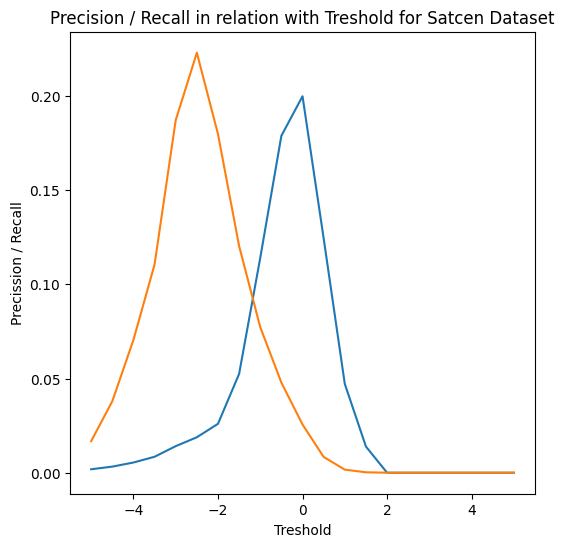

In [18]:
plt.figure(figsize=(6, 6))
plt.xlabel('Treshold')
plt.ylabel('Precission / Recall')
plt.title('Precision / Recall in relation with Treshold for Satcen Dataset')
# plt.xlim([0,1])
# plt.ylim([0,1])

recall_total_s = []
precision_total_s = []

precision_total_s = sorted(precision_s.items())
xp_s, yp_s = zip(*precision_total_s)


recall_total_s = sorted(recall_s.items())
xr_s, yr_s = zip(*recall_total_s)

# for treshold in [x / 2 for x in range(-10, 11)]:
#     recall_total_s.append(recall_s[treshold])
#     precision_total_s.append(precision_s[treshold])


plt.plot(xp_s, yp_s)
plt.plot(xr_s, yr_s)
plt.show()


<Figure size 640x480 with 0 Axes>

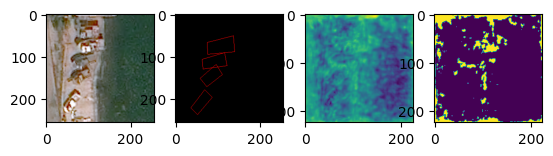

<Figure size 640x480 with 0 Axes>

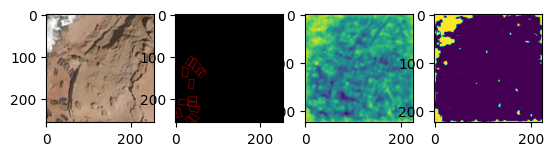

<Figure size 640x480 with 0 Axes>

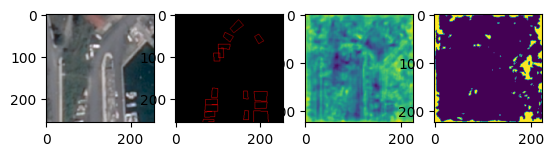

<Figure size 640x480 with 0 Axes>

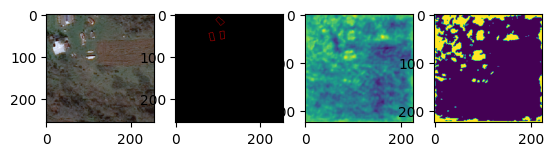

<Figure size 640x480 with 0 Axes>

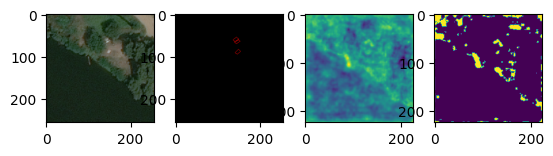

<Figure size 640x480 with 0 Axes>

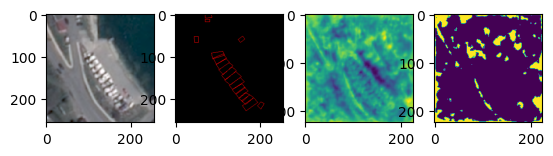

<Figure size 640x480 with 0 Axes>

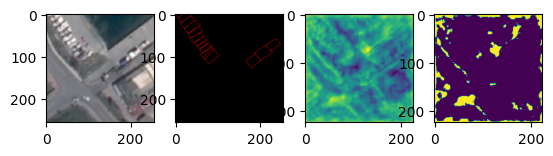

<Figure size 640x480 with 0 Axes>

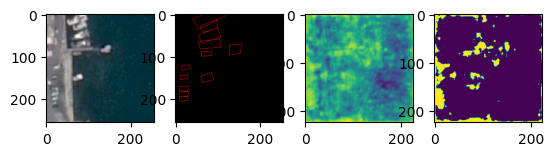

<Figure size 640x480 with 0 Axes>

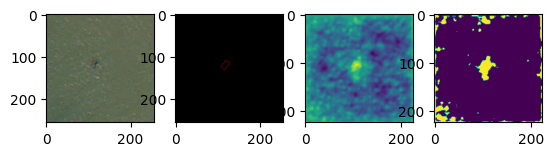

In [12]:
from scipy import ndimage
import skimage
import numpy
from tqdm import tqdm

files_name = ['0-0-0.png', '272-512-0.png', '1203-0-0.png', '1189-0-0.png', '119-0-0.png', '1191-0-0.png', '1193-0-0.png', '1195-0-0.png', '286-0-0.png']
for image in files_name:
    image_to_predict = Image.open('../satcen_dataset/pictures/' + image)
    ground_truth = Image.open(
        '../satcen_dataset/labeled_images_binary/' + image)
    
    if image_to_predict.mode == "L":
        rgbimg = Image.new("RGB", image_to_predict.size)
        rgbimg.paste(image_to_predict)
        image_to_predict = rgbimg
        
    image_to_predict_resized = numpy.asarray(image_to_predict.resize(size=(224, 224)))

    with testLearn.no_bar(), testLearn.no_logging():
        _, _, outputs = testLearn.predict(image_to_predict_resized)

    curated_output = np.copy(outputs.numpy()[1])
    for pixel in enumerate(curated_output):
        curated_output[pixel[0]] = [(k >= -3) * 1 for k in curated_output[pixel[0]]]

    plt.figure()

    f, axarr = plt.subplots(1,4) 
    axarr[0].imshow(image_to_predict)
    axarr[1].imshow(ground_truth)
    axarr[2].imshow(outputs[1])
    axarr[3].imshow(curated_output)
